In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from scipy.signal import resample
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader


from transformers import WhisperTokenizer
from transformers import WhisperFeatureExtractor
from transformers import WhisperForConditionalGeneration

import evaluate

wer  = evaluate.load('wer')



def down_sample_audio(audio_original, original_sample_rate):
    target_sample_rate = 16000

    # Calculate the number of samples for the target sample rate
    num_samples = int(len(audio_original) * target_sample_rate / original_sample_rate)

    # Resample the audio array to the target sample rate
    downsampled_audio = resample(audio_original, num_samples)

    return downsampled_audio

In [2]:
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small",language='bengali',task='transcribe')
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small",language='bengali',task='transcribe')
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to('cuda')

In [3]:
# from huggingface_hub import notebook_login
# notebook_login()

In [4]:
from datasets import load_dataset,concatenate_datasets

cv_17 = load_dataset("mozilla-foundation/common_voice_17_0", "or", split=["train","other","test"])

In [5]:
train_data = concatenate_datasets([cv_17[0],cv_17[1]])
test_data = cv_17[2]

In [6]:
text = train_data[0]['sentence']
text

'ଆଜି ମୁଁ ସର୍ପଦ୍ୱାରା କଣ ହୋଇଥାନ୍ତି ।'

In [7]:
len(train_data['sentence'][0])

33

In [8]:
for i,c in enumerate(train_data['sentence'][0]):
    print(i,c)

0 ଆ
1 ଜ
2 ି
3  
4 ମ
5 ୁ
6 ଁ
7  
8 ସ
9 ର
10 ୍
11 ପ
12 ଦ
13 ୍
14 ୱ
15 ା
16 ର
17 ା
18  
19 କ
20 ଣ
21  
22 ହ
23 ୋ
24 ଇ
25 ଥ
26 ା
27 ନ
28 ୍
29 ତ
30 ି
31  
32 ।


In [9]:
tok_sentence = tokenizer(train_data['sentence'][0])
for i,c in enumerate(tok_sentence.input_ids):
    print(i,c)

0 50258
1 50302
2 50359
3 50363
4 156
5 105
6 228
7 156
8 105
9 250
10 156
11 105
12 123
13 220
14 156
15 105
16 106
17 156
18 255
19 223
20 156
21 105
22 223
23 220
24 156
25 8357
26 156
27 105
28 108
29 156
30 255
31 235
32 156
33 105
34 103
35 156
36 105
37 99
38 156
39 255
40 235
41 156
42 255
43 109
44 156
45 105
46 122
47 156
48 105
49 108
50 156
51 105
52 122
53 220
54 156
55 105
56 243
57 156
58 105
59 96
60 220
61 156
62 105
63 117
64 156
65 255
66 233
67 156
68 105
69 229
70 156
71 105
72 98
73 156
74 105
75 122
76 156
77 105
78 101
79 156
80 255
81 235
82 156
83 105
84 97
85 156
86 105
87 123
88 220
89 8703
90 97
91 50257


In [10]:
from IPython.display import clear_output
import time

for idx in range(len(tok_sentence.input_ids)):
    print(tokenizer.decode(tok_sentence.input_ids[:idx]))
    clear_output(wait=True)
    time.sleep(.01)

<|startoftranscript|><|bn|><|transcribe|><|notimestamps|>ଆଜି ମୁଁ ସର୍ପଦ୍ୱାରା କଣ ହୋଇଥାନ୍ତି ।


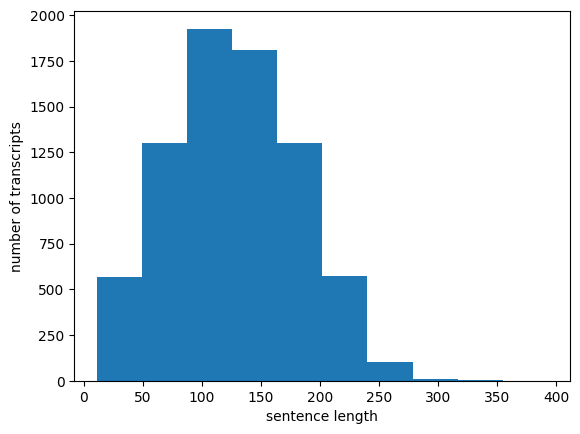

In [11]:
list_of_transcription_lengths = []

tokenized_text = tokenizer(train_data['sentence']).input_ids

for text in tokenized_text:
    list_of_transcription_lengths.append(len(text))
    # break

plt.hist(list_of_transcription_lengths)
plt.xlabel("sentence length")
plt.ylabel("number of transcripts")
plt.show()

In [17]:
import torch

for idx in range(5):

    target = train_data[idx]['sentence']
    audio_original = train_data[idx]['audio']['array']
    original_sample_rate = train_data[idx]['audio']['sampling_rate']

    audio_16000 = down_sample_audio(audio_original, original_sample_rate)

    input_feature = feature_extractor(raw_speech=audio_16000,
                                    sampling_rate=16000,
                                    return_tensors='pt').input_features

    with torch.no_grad():
        op = model.generate(input_feature.to('cuda'), language='bengali', task='transcribe')


    text_pred =  tokenizer.batch_decode(op,skip_special_tokens=True )[0]

    print(f'-------{idx}------')
    print(f'true : {target} \npred : {text_pred}')
    print('\n ')

-------0------
true : ଆଜି ମୁଁ ସର୍ପଦ୍ୱାରା କଣ ହୋଇଥାନ୍ତି । 
pred :  ḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍ

 
-------1------
true : ଏଠାରେ ନଦୀ ବୃଦ୍ଧିର କାରଣ ହେଲା ବୃଷ୍ଟି । 
pred :  अटरे नध्दि ब्रुछिरो करनो है ला ब्रुष्टी

 
-------2------
true : ଅସଲ କଥାଟା, ରାଜୀବଟା ଭାରି ଦୁଷ୍ଟ । 
pred :  अश्णलक अथा ता राजी बदा भारी दूस्टा

 
-------3------
true : ପ୍ରଭୁଙ୍କର ସେହିପରି ମହିମା, ନୋହିଲେ ନିଆଁ ତେଜରେ ଆଉ କିଏ ସେ ଘରେ ପଶି ପାରିବ? 
pred :  ḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍ

 
-------4------
true : ଆସାମୀ ଅଗଣା ମଧ୍ୟରୁ ନେତ ନାମକ ଏକରାସ ଧଳା ରଙ୍ଗର ଗାଈ ପୋଲିସ ବରାମଦ କରିଅଛି । 
pred :  ḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍḍ

 


In [13]:

class whisper_training_dataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len):#daatset is huggingface dataset object
        self.dataset = dataset
        self.max_len = max_len
        self.bos_token = model.config.decoder_start_token_id

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        audio_data = down_sample_audio(item['audio']["array"], item['audio']["sampling_rate"])
        input_features = feature_extractor(audio_data, sampling_rate=16000,return_tensors='pt').input_features[0]

        # Process the transcription
        transcription = item["sentence"]

        # Create labels
        labels = tokenizer(transcription, padding="max_length", max_length=self.max_len, truncation=True, return_tensors="pt")
        labels = labels["input_ids"].masked_fill(labels['attention_mask'].ne(1), -100)
        labels = labels[0][1:]


        return {
            "input_features": input_features,
            "labels": labels
        }

In [14]:
dataset = whisper_training_dataset(dataset=train_data, max_len=300)

train_dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=8,  # Adjust batch size as needed
    shuffle=True,  # Shuffle data during training
)

In [15]:
def evaluation(model):

    device='cuda'

    test_dataset = whisper_training_dataset(dataset=test_data, max_len=300)

    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=8,  # Adjust batch size as needed
        shuffle=True,  # Shuffle data during training
    )

    model.eval()

    predictions=[]
    references=[]

    for batch in tqdm(test_dataloader,total=len(test_dataloader)):

        model.train()  # Set model to training mode

        input_features, labels = batch["input_features"].to(device), batch["labels"].to(device)

        with torch.no_grad():
            generated_tokens = model.generate(input_features=input_features,language='bengali', task='transcribe')
                        
        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
        predictions.extend(decoded_preds)
        references.extend(decoded_labels)

    WER = wer.compute(predictions=predictions, references=references) * 100

    return WER

In [18]:
# WER before the training
torch.cuda.empty_cache()
evaluation(model)

100%|██████████| 87/87 [09:35<00:00,  6.62s/it]


164.53400503778337

In [16]:
# from peft import LoraConfig, PeftModel, LoraModel, LoraConfig, get_peft_model

# config = LoraConfig(r=32, lora_alpha=64, target_modules=["q_proj", "v_proj", "q_proj", "out_proj"], lora_dropout=0.05, bias="none")

# model = get_peft_model(model, config)
# model.print_trainable_parameters()

# model.save_pretrained('lora_model')

# model = PeftModel.from_pretrained(model,model_id='lora_model')

# for n,p in model.named_parameters():
#     print(n,p.requires_grad)

# Filter parameters with requires_grad=True
# requires_grad_params = filter(lambda x: x[1].requires_grad, model.parameters())

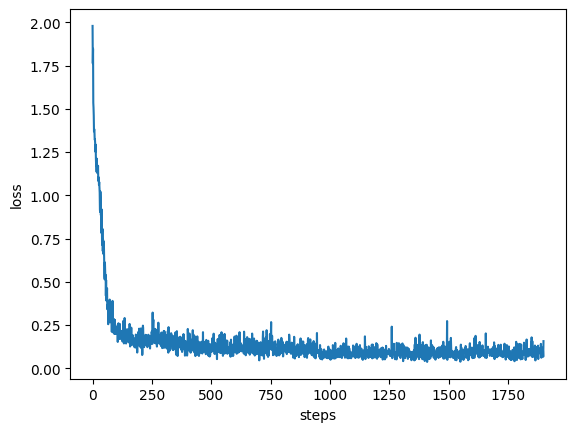

100%|██████████| 87/87 [05:47<00:00,  3.99s/it]  


In [ ]:
from IPython.display import clear_output
torch.cuda.empty_cache()

model.train()

device='cuda'

optimizer=torch.optim.AdamW(model.parameters(), lr=1e-5)
# optimizer=torch.optim.AdamW(requires_grad_params, lr=5e-4) # Only for LoRA Training

max_epochs=2


running_wer=[]
running_loss=[]



for epoch in range(max_epochs):

    for batch in tqdm(train_dataloader,total=len(train_dataloader),leave=False):

        model.train()  # Set model to training mode

        input_features, labels = batch["input_features"].to(device), batch["labels"].to(device)

        # Forward pass
        outputs = model(input_features, labels=labels)  # Assuming your model takes these inputs
        loss = outputs.loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()  # Reset gradients

        running_loss.append(loss.item())

        if len(running_loss) % 50 ==0:  # Print loss every 100 batches
            plt.plot(running_loss)
            plt.xlabel('steps')
            plt.ylabel('loss')
            clear_output(wait=True)  # Clear the output to keep the plot clean
            plt.show()

        if len(running_loss) % 100 == 0:  # Save model every 1000 steps
            # torch.save(model.state_dict(), f'finetuned_on_odia_steps_{len(running_loss)}.pth')
            model.save_pretrained('lora_model')

    torch.cuda.empty_cache()
    running_wer.append(evaluation(model))
    


In [19]:
model.load_state_dict(torch.load('finetuned_on_odia_steps_1000.pth', weights_only=True))# loading the model
model.eval()
model.to('cuda')


torch.cuda.empty_cache()
evaluation(model)

100%|██████████| 87/87 [05:19<00:00,  3.67s/it]


41.10831234256927

In [18]:
model.eval()

test_data = load_dataset("mozilla-foundation/common_voice_17_0", "or", split="test")

for idx in range(5):

    target = test_data[idx]['sentence']
    audio_original = test_data[idx]['audio']['array']
    original_sample_rate = test_data[idx]['audio']['sampling_rate']

    audio_16000 = down_sample_audio(audio_original, original_sample_rate)

    input_feature = feature_extractor(raw_speech=audio_16000,
                                    sampling_rate=16000,
                                    return_tensors='pt').input_features

    with torch.no_grad():
        op = model.generate(input_feature.to('cuda'), language='bengali', task='transcribe')


    text_pred =  tokenizer.batch_decode(op,skip_special_tokens=True )[0]

    print(f'-------{idx}------')
    print(f'true : {target} \npred : {text_pred}')
    print('\n ')

-------0------
true : ମଜଲିସ ଆଗରେ ଦର ଛିଣ୍ତିଲା ଅଢ଼େଇ ଟଙ୍କା । 
pred : ମଜଲିସ ଆଗରେ ଦର ଛଣ୍ଡିଲା ଅଢ଼େଇ ଟଙ୍କା ।

 
-------1------
true : ପହିଲୁ ପହିଲୁ କହିଲୁ, ପାଠ ପଢ଼ି ସାରିଲେ ବାହା ହେବୁ । 
pred : ପହିଲୁ, ପହିଲୁ, କହିଲୁ, ପାଠ ପଢ଼ି ସାରିଲେ ବାହା ହେବୁ ।

 
-------2------
true : ସେହି ଶବ୍ଦ ଶୁଣି ବିଲୁଆ ଧଡ଼ପଡ଼ ହୋଇ ପଳାଇଗଲା । 
pred : ସେହି ଶବ୍ଦ ଶୁଣି ବିଲ୍ଵା ଢ଼ ପଡ଼ ହୋଇ ପଳାଇଗଲା ।

 
-------3------
true : ଆପଣ ଛେଉଣ୍ଡଟିକୁ ଟିକିଏ ଦୟା କରନ୍ତୁ, ସେହି ପାଞ୍ଚଶରେ ମଙ୍ଗି ଯାନ୍ତୁ । 
pred : ଆପଣ ଅ ଛେଉଁଟଟିକୁ ଉଟିକେ ଦୟାକରନ୍ତ ସେଇ ପାଚାଷରେ ପଙ୍କି ଯେନ୍ଥୁ ।

 
-------4------
true : ଛଅ 
pred : ଛଅ

 


WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 768)
      (layers): ModuleList(
        (0-11): 12 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        

In [19]:
from transformers import pipeline

pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=tokenizer,
    feature_extractor=feature_extractor,
    chunk_length_s=30, 
    stride_length_s=10, 
    device='cuda',
)

In [20]:
result = pipe("odia_audio_youtube.mp3")
result

c:\Users\User\miniconda3\envs\torch_env\Lib\site-packages\transformers\models\whisper\generation_whisper.py:509: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.


{'text': 'କ୍ୟାଦେକୁଛନ୍ତି ଗୋଟଉଛି କଲମ ଗୋଟଉଛି ରୁମାଲ ଗୋଟଉଛି ଘଣ୍ତା, ଏଇ ତିନିଟା ଭୁଲେ ମଧ୍ୟ କାରୁ ଗିଥ୍ଣେବେନି କି ଗିଥିପ୍ଥିବ୍ତି ଘିଥିପ୍ଥିନି କିଥିପ୍ଥିପ୍ଥିପ୍ଥିପ୍ଥିପ୍ଥିପ୍ଥିପ୍ଥିପ୍ଥିପ୍ଥିପ୍ଥନେଇ ଯାଉଛନ୍ତି, ସେଇଟା ଆପଣଙ୍କର ଗୁର୍ ଗୁର୍ଲକ୍ ମାନେ ଭଲାର ଭଲେର ଆପଣଙ୍କର କାହାକୁ ଦେଇ ଦେଇ ଦେଇଦେବିଥିବେ ଦାନ ଅଲଗା ଦକେତିଣା ଲଗା, ଦକ୍ଷିଣା ମାନେ ତାଙ୍କୁ କହିଥାହୁ ଯେତେବିକୁ ଆମରକୁଣସି ପୂଜାପାଠ କରିଥାଉ ଆମରରନଣଭଭରାମଙ୍କୁ କିଛିଜୁର ଦେଇଥାହୁ ସେଟାହୁଛି ଦକିଛି ଆମରାମରଭ�ନ ବ୍ରାମଣଙ୍କୁ କିଛଦକ୍ଷିଣା ମାନେ ତାଙ୍କ ଦାନ କିଛି କର୍ମ କରେଇଲେ ଯେବାପଳରେ ଆମେ ତାଙ୍କୁ କିଛି ପ୍ରାପ୍ୟ ସେଉମ୍ଧାଇ ଦେଲେ କିନ୍ତୁ ଦାନଟାହୁଇଛି ସମ୍ପୂନ ଅଲୋଗା, ଆମର ବେଳବେବେକଣ ହେର ଆନଭେଲେ ଆପଣିଥିବିବିବିବିବିବିବି'}